In [1]:
import os
import glob
import itertools
import json
import importlib

import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import statsmodels.api as sm


In [2]:
import analyze2p.plotting as pplot
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.utils as hutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.extraction.traces as traceutils
import copy

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [4]:
%matplotlib notebook

In [5]:
# import sys
# !{sys.executable} -m pip install shapely

# Plotting params

In [6]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(lw_axes=0.25)

# Source data

In [7]:
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
traceid = 'traces001'
fit_thr=0.5
# -----------------------------------------------------
do_spherical_correction=False
response_type='dff'

# Load data

In [8]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
rf_meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()

rf_dkeys = [(va, dk) for (va, dk), g in rf_meta.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in rf_dkeys])
counts = aggr.count_n_cells(CELLS)
print(counts.groupby('visual_area').sum().to_markdown())

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
| visual_area   |   n_cells |
|:--------------|----------:|
| Li            |      2243 |
| Lm            |      2990 |
| V1            |      4009 |


In [9]:
# Get RF fit description (tag for which RF analysis to load)
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                   do_spherical_correction=do_spherical_correction)
data_id = '%s_%s' % (traceid, rf_fit_desc)
print(data_id)
# Set output dir
dst_dir = os.path.join(aggregate_dir, 'receptive-fields', 
                       '%s__%s' % (traceid, rf_fit_desc))
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

traces001_fit-2dgaus_dff-no-cutoff
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff


In [10]:
# Load RF fit params for good rois
# rfdata = rfutils.cycle_and_load(rf_meta, CELLS, reliable_only=True, 
#                         fit_desc=rf_fit_desc, traceid=traceid, verbose=False)
rfdata = rfutils.aggregate_rfdata(rf_meta, CELLS, fit_desc=rf_fit_desc)
# Get ROI positions
rfdata = aggr.add_roi_positions(rfdata)

N dpaths: 56, N unfit: 0
N datasets included: 61, N sessions excluded: 4


In [11]:
counts = aggr.count_n_cells(rfdata, 
                            count_cols=['visual_area', 'datakey', 'experiment', 'cell'])
print(counts.groupby(['visual_area', 'experiment']).sum())

                        n_cells
visual_area experiment         
Li          rfs              53
            rfs10           400
Lm          rfs             322
            rfs10            40
V1          rfs             603
            rfs10           571


In [12]:
counts

,visual_area,datakey,experiment,n_cells
0,Li,20190522_JC089_fov1,rfs,1
1,Li,20190522_JC089_fov1,rfs10,3
2,Li,20190527_JC092_fov3,rfs10,37
3,Li,20190528_JC092_fov1,rfs10,9
4,Li,20190602_JC091_fov1,rfs,42
5,Li,20190602_JC091_fov1,rfs10,65
6,Li,20190606_JC091_fov1,rfs10,32
7,Li,20190607_JC091_fov1,rfs10,48
8,Li,20190609_JC099_fov1,rfs10,30
9,Li,20190612_JC099_fov1,rfs10,40


# Example traces

In [12]:
import matplotlib.gridspec as gridspec

In [13]:
dst_dir = os.path.join(aggregate_dir, 'receptive-fields')

In [14]:
# Set output dir
curr_dst_dir = os.path.join(dst_dir, 'example_plots')
if not os.path.isdir(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/example_plots


In [22]:
va='Li'
counts[(counts.experiment=='rfs10') & (counts.visual_area==va)]\
        .sort_values(by='n_cells', ascending=False)


,visual_area,datakey,experiment,n_cells
10,Li,20190614_JC091_fov1,rfs10,69
5,Li,20190602_JC091_fov1,rfs10,61
7,Li,20190607_JC091_fov1,rfs10,54
2,Li,20190527_JC092_fov3,rfs10,36
9,Li,20190612_JC099_fov1,rfs10,35
8,Li,20190609_JC099_fov1,rfs10,34
6,Li,20190606_JC091_fov1,rfs10,31
14,Li,20191017_JC113_fov1,rfs10,28
12,Li,20191012_JC113_fov2,rfs10,19
17,Li,20191106_JC120_fov1,rfs10,18


In [21]:
va

'Li'

In [15]:
rows='ypos'
cols='xpos'
response_type='dff'
do_spherical_correction=False

# Set output dirs
# -----------------------------------------------------------------------------
# rf_param_str = 'fit-2dgaus_%s-no-cutoff' % (response_type)
# va='Li'
# dk='20190614_JC091_fov1'

# va='V1'
# dk='20190522_JC084_fov1'
# rf_type='rfs'

# va='Li'
# dk='20190614_JC091_fov1'
# rf_type='rfs10'

va='V1'
dk='20190616_JC097_fov1'
rf_type='rfs'

session, animalid, fovn = hutils.split_datakey_str(dk)
fov = 'FOV%i_zoom2p0x' % fovn

exp_name = 'gratings' if int(session)<=20190511 else rf_type
rfdir, fit_desc = rfutils.create_rf_dir(dk, rf_type, is_neuropil=False,
                                    response_type=response_type,
                                    do_spherical_correction=do_spherical_correction,
                                    traceid=traceid)
print(rfdir, fit_desc)

data_id = '|'.join([animalid, session, fov, rf_type, traceid, fit_desc])
print(data_id)

/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_e0b0a8_traces001_dd504a_traces001_0e6f9a_traces001_1c5b41_traces001_5483ef_traces001_9f6c47/receptive_fields/fit-2dgaus_dff-no-cutoff fit-2dgaus_dff-no-cutoff
JC097|20190616|FOV1_zoom2p0x|rfs|traces001|fit-2dgaus_dff-no-cutoff


In [16]:
importlib.reload(rfutils)

<module 'analyze2p.receptive_fields.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/receptive_fields/utils.py'>

In [17]:
# Fit results
fit_results, fit_params = rfutils.load_fit_results(dk, 
                            experiment=rf_type, traceid=traceid,
                            response_type=response_type,
                            do_spherical_correction=do_spherical_correction)

In [18]:
# curr_rois = rfdata[(rfdata.visual_area==va) & 
#                    (rfdata.datakey==dk) & (rfdata.experiment==rf_type)]['cell'].unique()

curr_rois = CELLS[(CELLS.visual_area==va) & (CELLS.datakey==dk)]['cell'].unique()

In [19]:
fit_thr=0.5
fitdf_all = rfutils.rfits_to_df(fit_results, fit_params,
                                scale_sigma=False, convert_coords=True)
                    #fit_params=fit_params) #, #spherical=do_spherical_correction,
                    #row_vals=fit_params['row_vals'], col_vals=fit_params['col_vals'])
incl_rois = [k for k in curr_rois if k in fitdf_all.index.tolist()]
fitdf = fitdf_all.loc[incl_rois]

fit_rois = fitdf[fitdf['r2'] > fit_thr].sort_values('r2', axis=0, 
                                            ascending=False).index.tolist()
len(fit_rois)

103

In [20]:
eval_results, eval_params = rfutils.load_eval_results(dk, 
                                    rfdir=fit_params['rfdir'],
                                    fit_desc=fit_desc)      

pass_criterion = ['position', 'size']
all_reliable_rois = rfutils.get_reliable_fits(eval_results['pass_cis'],
                                    pass_criterion=pass_criterion)
reliable_rois = [k for k in fit_rois if k in all_reliable_rois]
print("%i of %i fit rois pass crit: %s" \
          % (len(reliable_rois), len(fit_rois), pass_criterion))

fit_roi_list = copy.copy(reliable_rois)


98 of 103 fit rois pass crit: ['position', 'size']


In [41]:
# Get data source
traceid_dir = rfdir.split('/receptive_fields/')[0]
soma_fpath = os.path.join(traceid_dir, 'data_arrays', 'np_subtracted.npz')

traces, labels, sdf, run_info = traceutils.load_dataset(soma_fpath, 
                                    trace_type='corrected',create_new=False)
#  Z-score or dff the traces:
trace_type='zscore'
response_type = fit_params['response_type']
print(trace_type, response_type)
zscored_traces, zscores = aggr.process_traces(traces, labels,
                                trace_type='dff',
                                response_type=response_type,
                                nframes_post_onset=fit_params['nframes_post_onset'])

zscore dff
--- processed traces: dff


In [42]:
sdf

,direction,luminance,stimtype,xpos,ypos,aspect,ori,position,speed,sf,size
config001,0,None,gratings,-50.0,-25.0,1,0,"(-50, -25)",10,0.25,5.0
config002,0,None,gratings,-50.0,-20.0,1,0,"(-50, -20)",10,0.25,5.0
config003,0,None,gratings,-50.0,-15.0,1,0,"(-50, -15)",10,0.25,5.0
config004,0,None,gratings,-50.0,-10.0,1,0,"(-50, -10)",10,0.25,5.0
config005,0,None,gratings,-50.0,-5.0,1,0,"(-50, -5)",10,0.25,5.0
...,...,...,...,...,...,...,...,...,...,...,...
config227,0,None,gratings,50.0,5.0,1,0,"(50, 5)",10,0.25,5.0
config228,0,None,gratings,50.0,10.0,1,0,"(50, 10)",10,0.25,5.0
config229,0,None,gratings,50.0,15.0,1,0,"(50, 15)",10,0.25,5.0
config230,0,None,gratings,50.0,20.0,1,0,"(50, 20)",10,0.25,5.0


In [48]:
cfgs_=sdf.index.tolist()
rid = 164
tdf = traceutils.get_mean_and_std_traces(rid, traces, labels, cfgs_, sdf, 
                                smooth=True, win_size=5,
                                param='position', return_stacked=True)

In [52]:
tdf['xpos'] = [v[0] for v in tdf['position'].values]
tdf['ypos'] = [v[1] for v in tdf['position'].values]
tdf.head()

,time,position,mean,sem,xpos,ypos
0,-0.492677,"(-50, -25)",1019.111035,23.586274,-50,-25
1,-0.470282,"(-50, -25)",1014.606654,23.536925,-50,-25
2,-0.447888,"(-50, -25)",1020.588414,21.304588,-50,-25
3,-0.425494,"(-50, -25)",1006.608532,22.505422,-50,-25
4,-0.403099,"(-50, -25)",999.794061,23.124541,-50,-25


<IPython.core.display.Javascript object>


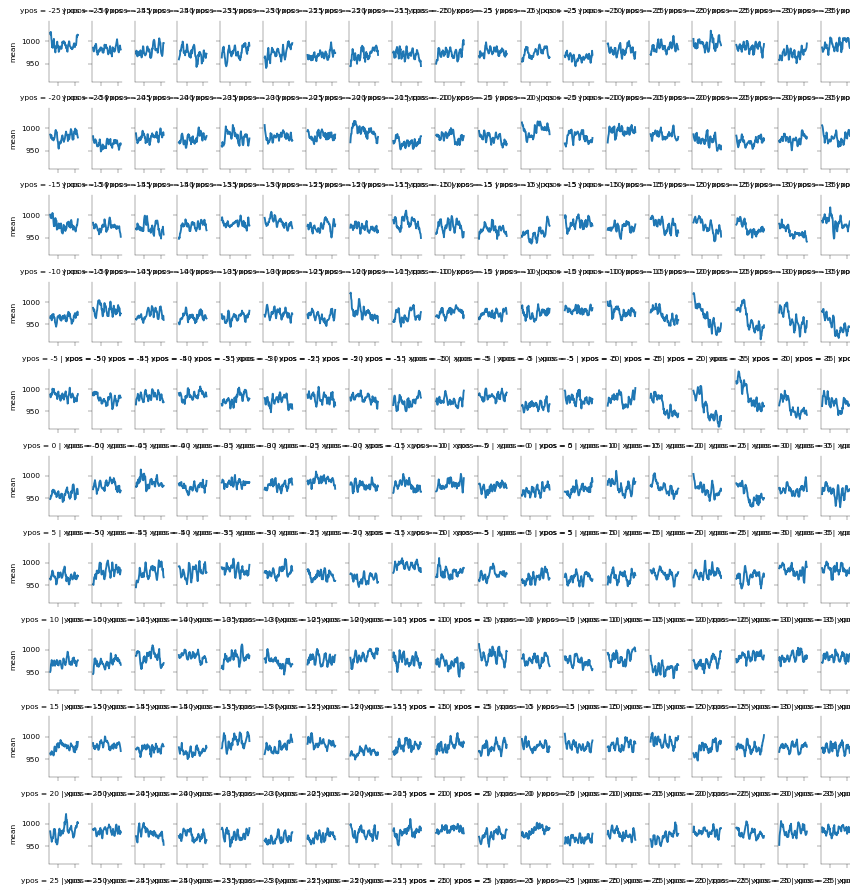

In [56]:
fg = sns.FacetGrid(col='xpos', row='ypos', data=tdf, height=1, aspect=0.5)
fg.map(pl.plot, 'time', 'mean' )

In [26]:
# Get RFMAPS
avg_resp_by_cond0 = rfutils.load_rfmap_array(fit_params['rfdir'], do_spherical_correction=do_spherical_correction)
# if avg_resp_by_cond0 is None:
#     trials_by_cond = rfutils.get_trials_by_cond(labels)
#     nx = len(fit_params['col_vals'])
#     ny = len(fit_params['row_vals'])
#     print("Error loading array, extracting now")
#     print("...getting avg by cond")
#     avg_resp_by_cond0 = rfutils.group_trial_values_by_cond(zscores, trials_by_cond, nx=nx, ny=ny,
#                                                 do_spherical_correction=do_spherical_correction)
#     if do_spherical_correction:
#         print("...doin spherical warps")
#         if n_processes>1:
#             avg_resp_by_cond0 = sphr_correct_maps_mp(avg_resp_by_cond0, fit_params,
#                                                         n_processes=n_processes, test_subset=test_subset)
#         else:
#             avg_resp_by_cond0 = sphr_correct_maps(avg_resp_by_cond0, fit_params,
#                                                         multiproc=False)
#     print("...saved array")
#     rfutils.save_rfmap_array(avg_resp_by_cond0, fit_params['rfdir'])
avg_resp_by_cond = avg_resp_by_cond0[fit_roi_list]   

In [27]:
# Stim info
stim_on_frame = labels['stim_on_frame'].unique()[0]
nframes_on = labels['nframes_on'].unique()[0]
stim_on_sec = round(stim_on_frame/44.65, 1)
nframes_plot = fit_params['stim_on_frame'] + fit_params['nframes_on'] + fit_params['nframes_post_onset']
start_frame = fit_params['stim_on_frame'] #stim_on_frame #plot_start_frame #stim_on_frame #0
yunit_sec = round(fit_params['nframes_on']/fit_params['frame_rate'], 1)
# Add stim info to labels df for plotting
labels['xpos'] = sdf.loc[labels['config']]['xpos'].values
labels['ypos'] = sdf.loc[labels['config']]['ypos'].values
# position info
xpos = list(sorted(sdf['xpos'].unique()))
ypos = list(sorted(sdf['ypos'].unique()))
row_vals=fit_params['row_vals']
col_vals=fit_params['col_vals']
n_xpos = len(xpos)
n_ypos = len(ypos)

In [28]:
plot_ellipse=True
ellipse_ec='w'
ellipse_fc='none'
ellipse_lw=0.5
ellipse_alpha=1

fill_sem=True
mean_only=False
ls='-'
lw=0.5
legend_lw = 0.5

scale_sigma=True
sigma_scale=2.35
linecolor='darkslateblue'
cmap='bone'
legend_lw=0.25

nframes_plot = fit_params['stim_on_frame'] + fit_params['nframes_on'] #+ fit_params['nframes_post_onset']
start_frame = fit_params['stim_on_frame'] #stim_on_frame #plot_start_frame #stim_on_frame #0
yunit_sec = 0.5 #1.0 #round(fit_params['nframes_on']/fit_params['frame_rate'], 1)
yunit_frames = yunit_sec*44.65

In [32]:
if va=='Lm' and dk=='20190603_JC080_fov1':
    example_roi_list = [85, 128, 170]
elif va=='Lm' and dk=='20190508_JC083_fov1':
    example_roi_list = [31, 209, 44] #237, 44]
elif va=='V1' and dk=='20190616_JC096_fov1':
    example_roi_list = [388, 381, 66]
elif va=='Li' and dk=='20190602_JC091_fov1':
    example_roi_list = [33,43,275]
elif va=='Li' and dk=='20190614_JC091_fov1':
    example_roi_list = [211,234,248]
elif va=='V1' and dk=='20190616_JC097_fov1':
    example_roi_list = [165, 172, 175]
else:
    example_roi_list = fit_roi_list[0:3]
example_roi_list

[165, 172, 175]

In [33]:
va, dk

('V1', '20190616_JC097_fov1')

In [37]:
rid = 164
rid in fit_roi_list

True

In [38]:

currt = labels.copy()
currt[response_type] = zscored_traces[rid].copy()
# Get curreent rf map
map_values = avg_resp_by_cond[rid].values
rfmap = np.flipud(map_values.reshape(len(col_vals), len(row_vals)).T) # fipud to match screen
print(rfmap.max())

0.021518647690837004


In [40]:
%matplotlib notebook
vmin=-0.1
vmax=0.1
set_ymax = vmax

ytick_max = 1.0
units = 'stds' if trace_type=='zscore' else 'df/f'

vmin = np.nanmin(rfmap) if vmin is None else vmin
vmax = np.nanmax(rfmap) if vmax is None else vmax
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmapper = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
fig, axn = pl.subplots(n_ypos, n_xpos, figsize=(10, 5.7), sharex=True, sharey=True)
for (yp, xp), g in currt.groupby(['ypos', 'xpos']):
    yi = ypos[::-1].index(yp)
    xi = xpos.index(xp)
    ax=axn[yi, xi]
    #ax.set_title('%i, %i' % (xp, yp))
    ax.patch.set(alpha=1)
    pcolor = cmapper.to_rgba(rfmap[yi, xi])
    ax.patch.set_color(pcolor)
    t_df = g.groupby(['trial'])['dff'].apply(traceutils.smooth_traces_trial, win_size=5).unstack().T
    mean_t = np.nanmean(t_df, axis=1)[start_frame:start_frame+nframes_plot]
    std_t = np.nanstd(t_df, axis=1)[start_frame:start_frame+nframes_plot]
    sem_t = spstats.sem(t_df, axis=1, nan_policy='omit')[start_frame:start_frame+nframes_plot]
    ax.fill_between(np.arange(0, len(mean_t)), mean_t-sem_t, mean_t+sem_t, alpha=0.2, color='k')
    ax.plot(mean_t, lw=lw, c='k', linestyle=ls) #, label='%s %i' % (hue_, curr_hue))
    # format
    if not (xi==0 and yi==len(ypos)-1):
        sns.despine(bottom=True, left=True, ax=ax)
    else:
        sns.despine(trim=True, ax=ax) #, bottom=True, left=True, ax=ax)  
    ax.set_xticks([stim_on_frame, stim_on_frame+nframes_on])
    ax.tick_params(which='both', axis='both', size=0)
    ax.set_xticklabels([])
    ax.set_xlabel('') 
    # Make sure y-ticks are limited correctly
    ax.set_yticks(np.linspace(0, ytick_max, 3)) #[0.0, 0.1, 0.2])
    ax.set_yticklabels(['', '%.1f %s' % (ytick_max, units), ''], rotation=90)

# Set axis LIMITS for ALL, just make sure it's the same
subplot_xlims = ax.get_xlim() 
subplot_ylims = ax.get_ylim() 
ax.set_ylim(subplot_ylims)
ax.set_xlim(subplot_xlims)
subplot_pos = ax.get_position()
for ax in axn.flat: #axes.flat:
    ax.set_ylim(subplot_ylims)
    ax.set_xlim(subplot_xlims)
    ax.tick_params(axis='both', which='both', length=0, labelsize=0)
    ax.set_xticks([])
    ax.set_yticks([])
    curr_pos = ax.get_position()
    new_pos = [curr_pos.x0, curr_pos.y0, subplot_pos.width, subplot_pos.height] #.1, .1]
    ax.set_position(new_pos)
pl.subplots_adjust(left=0.02, right=0.8, wspace=0, hspace=0)

# plot ellipse
pos_ylim = (min(row_vals), max(row_vals))
pos_xlim = (min(col_vals), max(col_vals))
screen_xlim_centered = rfutils.get_centered_screen_points(pos_xlim, n_xpos)
screen_ylim_centered = rfutils.get_centered_screen_points(pos_ylim, n_ypos)
outergs = gridspec.GridSpec(1,1)
outerax = fig.add_subplot(outergs[0])
outerax.tick_params(axis='both', which='both', bottom=0, left=0,
                labelbottom=0, labelleft=0)
outerax.set_facecolor('crimson')
outerax.patch.set_alpha(0.1)
outerax = fig.add_subplot(outergs[0])
outerax.set_ylim(screen_ylim_centered) #[screen_bottom, screen_top])
outerax.set_xlim(screen_xlim_centered) #[screen_left, screen_right])

ell = mpl.patches.Ellipse((fitdf['x0'][rid], fitdf['y0'][rid]),
                abs(fitdf['sigma_x'][rid])*sigma_scale,
                abs(fitdf['sigma_y'][rid])*sigma_scale,
                angle=np.rad2deg(fitdf['theta'][rid]))
ell.set_alpha(ellipse_alpha)
ell.set_edgecolor(ellipse_ec)
ell.set_facecolor(ellipse_fc)
ell.set_linewidth(ellipse_lw)
outerax.add_patch(ell)
# Add colorbar for RF map
cmapper._A = []
cbar_ax = fig.add_axes([0.81, 0.15, 0.015, 0.3])
cbar = fig.colorbar(cmapper, cax=cbar_ax)
cbar.set_label('%s' % response_type)
cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels([round(vmin, 2), round(vmax, 2)])
cbar.ax.tick_params(axis='both', which='both', length=0, pad=1)

# Add legend for traces
legend_pos = [0.83, 0.75, subplot_pos.width, subplot_pos.height] #.1, .1]
leg = fig.add_subplot(111, position=legend_pos) #, aspect='auto')
leg.clear()
leg.plot(mean_t, 'w', alpha=1)
leg.set_ylim(subplot_ylims)
leg.set_xlim(subplot_xlims)
ymax = ax.get_ylim()[-1] if set_ymax is None else set_ymax
yscale = min([ymax, 2.0]) if trace_type=='zscore' else min([ymax, 0.5])
# set lim
ymin, ymax = subplot_ylims
leg.set_yticks([ymin, ymin+yscale])
yunits = 'std' if trace_type=='zscore' else response_type
leg.set_ylabel('%.1f %s' % (yscale, yunits))
xmin, xmax = subplot_xlims
leg.set_xticks([xmin, xmin+yunit_frames])
leg.set_xticklabels([])
# legends
leg.tick_params(axis='both', which='both', size=0, labelsize=0, pad=0.01)
for axlabel in ['left', 'bottom']:
    leg.spines[axlabel].set_linewidth(legend_lw)
leg.set_xlabel('%.1f s' % yunit_sec, horizontalalignment='left', x=0)
sns.despine(ax=leg, trim=True, offset=0) #, bottom=False)

pplot.label_figure(fig, data_id)
fig.suptitle('roi %i' % int(rid+1))
figname = '%s_%s_roi%05d_overlay_test' % (va, dk, int(rid+1))
# pl.savefig(os.path.join(curr_dst_dir, '%s.pdf' % (figname)), bboxx_inches='tight')
print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


KeyboardInterrupt



In [50]:
importlib.reload(traceutils)

<module 'analyze2p.extraction.traces' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/extraction/traces.py'>

In [124]:
# def plot_rfs_to_screen_pretty(fitdf, sdf, screen, sigma_scale=2.35, fit_roi_list=[], ax=None,
#                              ellipse_lw=1, roi_colors=None):
#     '''
#     fitdf:  dataframe w/ converted fit params
#     '''
#     screen_left = -1*screen['azimuth_deg']/2.
#     screen_right = screen['azimuth_deg']/2.
#     screen_top = screen['altitude_deg']/2.
#     screen_bottom = -1*screen['altitude_deg']/2.
    
#     row_vals = sorted(sdf[rows].unique())
#     col_vals = sorted(sdf[cols].unique())
#     tile_sz = np.mean(np.diff(row_vals))
#     screen_rect = mpl.patches.Rectangle(
#                 ( min(col_vals)-tile_sz/2., min(row_vals)-tile_sz/2.), 
#                 max(col_vals)-min(col_vals)+tile_sz,
#                 max(row_vals)-min(row_vals)+tile_sz, 
#                 facecolor='none', edgecolor='k', lw=0.5)
#     ax.add_patch(screen_rect)
#     if ax is None:
#         fig, ax = pl.subplots(figsize=(12, 6))
#         fig.patch.set_visible(False) #(False) #('off')
#     if roi_colors is None:
#         roi_colors=sns.color_palette('bone', n_colors=len(fit_roi_list)+5) 
#     for rid, rcolor in zip(fit_roi_list, roi_colors):
#         ell = mpl.patches.Ellipse((fitdf['x0'][rid], fitdf['y0'][rid]),
#                       abs(fitdf['sigma_x'][rid])*sigma_scale, abs(fitdf['sigma_y'][rid])*sigma_scale,
#                       angle=np.rad2deg(fitdf['theta'][rid]))
#         ell.set_alpha(1.0)
#         ell.set_linewidth(ellipse_lw)
#         ell.set_edgecolor(rcolor)
#         ell.set_facecolor('none')
#         ax.add_patch(ell)
#     ax.set_ylim([screen_bottom, screen_top])
#     ax.set_xlim([screen_left, screen_right])
    
#     ax.set_xticks([])
#     ax.set_xticklabels([])
#     ax.set_yticks([])
#     ax.set_yticklabels([])
#     #summary_str = "Avg sigma-x, -y: (%.2f, %.2f)\nAvg RF size: %.2f (min: %.2f, max: %.2f)" % (np.mean(majors), np.mean(minors), np.mean([np.mean(majors), np.mean(minors)]), avg_rfs.min(), avg_rfs.max())
#     #pl.text(ax.get_xlim()[0]-12, ax.get_ylim()[0]-8, summary_str, ha='left', rotation=0, wrap=True)
#     return ax


In [125]:
screen = hutils.get_screen_dims()
screen

{'azimuth_deg': 119.5564,
 'altitude_deg': 67.323,
 'azimuth_cm': 103.0,
 'altitude_cm': 58.0,
 'resolution': [1920, 1080],
 'deg_per_pixel': (0.06226895833333333, 0.062336111111111106)}

<IPython.core.display.Javascript object>


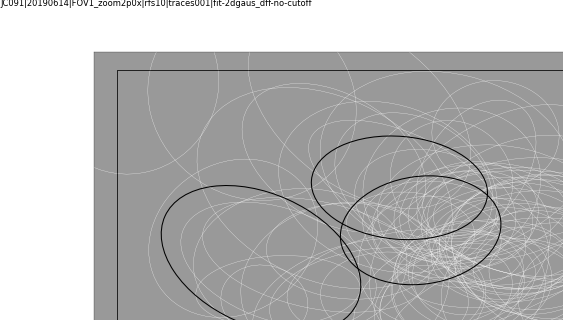

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bboxx_inches" which is no longer supported as of 3.3 and will become an error two minor releases later


/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields screen_rfs__Li_20190614_JC091_fov1_test


In [126]:
fig, ax = pl.subplots(figsize=(10, 5.7))
fig.patch.set_visible(False) #(False) #('off')

other_rois = [r for r in fit_roi_list if r not in example_roi_list]
ax = rfutils.plot_rfs_to_screen_pretty(fitdf, sdf, screen, 
                               sigma_scale=fit_params['sigma_scale'],
                               fit_roi_list=other_rois, ax=ax, 
                               roi_colors=['w']*len(other_rois), ellipse_lw=0.25)

ax = rfutils.plot_rfs_to_screen_pretty(fitdf, sdf, screen, 
                               sigma_scale=fit_params['sigma_scale'],
                               fit_roi_list=example_roi_list, ax=ax, 
                               roi_colors=['k']*3, ellipse_lw=1)
ax.patch.set_color([0.6]*3)
ax.patch.set_alpha(1)

pplot.label_figure(fig, data_id)
figname = 'screen_rfs__%s_%s_test' % (va, dk)
pl.savefig(os.path.join(dst_dir, '%s.pdf' % (figname)), bboxx_inches='tight')

print(dst_dir, figname)